In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from tqdm import tqdm
import os, sys, numpy as np, cv2
from scipy import signal
from skimage.util import img_as_float
from skimage.io import imread
import matplotlib
from matplotlib import pyplot as plt
import math
from scipy.ndimage.filters import *
from skimage.transform import *
import time

In [13]:
def show_all_circles(image, cx, cy, rad, output_dir, imname, color='r'):
    
    """
    image: numpy array, representing the grayscsale image
    cx, cy: numpy arrays or lists, centers of the detected blobs
    rad: numpy array or list, radius of the detected blobs
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.imshow(image, cmap='gray')
    for x, y, r in zip(cx, cy, rad):
        # print(len(x), len(y), len(r))
        circ = Circle((x, y), r, color=color, fill=False)
        ax.add_patch(circ)

    plt.title('%i circles' % len(cx))
    filename = os.path.join(output_dir, imname +'.png')
    plt.savefig(filename)
    plt.show()

In [14]:
# set some constant parameters
IMAGE_DIR = 'blobs-data'
OUTPUT_DIR = 'blobs-output'
imlist = ['101085', '119082', '182053', '210088', 'butterfly', 'einstein', 'fishes', 'sunflowers']

In [15]:
def find_circle_parta(I, sigma_start=2, levels=15, k=1.2, threshold=0.001):
    # in this function, use the naive method to find location of circles
    height, width = I.shape
    sigma_start = 2
    levels = 15
    k = 1.2
    scale_space = np.zeros((levels, height, width))
    laplace_space = np.zeros((levels, height, width))
    for i in range(levels):
        # in each level, we conpute the convolution of I and laplace
        sigma = sigma_start * k ** i;
        laplace = sigma**2 * gaussian_laplace(I, sigma=sigma)
        laplace = laplace * laplace
        laplace_space[i, :, :] = laplace
        cur_size = math.ceil(sigma*np.sqrt(2))
        rank = rank_filter(laplace, rank=-1, size=(cur_size, cur_size))
        scale_space[i, :, :] = rank
    
    global_max = np.zeros_like(scale_space)
    # find the global maximum
    temp_max = rank_filter(scale_space, rank=-1, size=(levels, 3, 3))
    global_max = np.where(temp_max <= laplace_space, laplace_space, 0)
    global_max = np.where(global_max >= threshold, global_max, 0)
    # now we need to draw circles
    cx, cy, rad = [], [], []
    for i in range(levels):
        cur_cy, cur_cx = np.where(global_max[i, :, :] > 0)
        cur_rad = [np.sqrt(2) * sigma_start * k ** i] * cur_cy.shape[0]
        cx.extend(list(cur_cx))
        cy.extend(list(cur_cy))
        rad.extend(cur_rad)
    return cx, cy, rad
    
    
def find_circle_partb(I, sigma=2, levels=15, k=1.2, threshold=0.001):
    height, width = I.shape
    scale_space = np.zeros((levels, height, width))
    laplace_space = np.zeros((levels, height, width))
    for i in range(levels):
        new_height, new_width = math.ceil(height / k ** i), math.ceil(width / k ** i)
        cur_I = resize(I, (new_height, new_width))
        laplace = sigma**2 * gaussian_laplace(cur_I, sigma=sigma)
        laplace = laplace * laplace        
        # we need to resize the output
        laplace = resize(laplace, (height, width))
        laplace_space[i, :, :] = laplace
        # cur_size = math.ceil(sigma*np.sqrt(2))
        cur_size = math.ceil(sigma*k**i * np.sqrt(2))
        rank = rank_filter(laplace, rank=-1, size=(cur_size, cur_size))
        scale_space[i, :, :] = rank

    global_max = np.zeros_like(scale_space)
    # find the global maximum
    temp_max = rank_filter(scale_space, rank=-1, size=(levels, 3, 3))
    global_max = np.where(temp_max <= laplace_space, laplace_space, 0)
    global_max = np.where(global_max >= threshold, global_max, 0)
    # now we need to draw circles
    cx, cy, rad = [], [], []
    for i in range(levels):
        cur_cy, cur_cx = np.where(global_max[i, :, :] > 0)
        cur_rad = [np.sqrt(2) * sigma * k ** i] * cur_cy.shape[0]
        cx.extend(list(cur_cx))
        cy.extend(list(cur_cy))
        rad.extend(cur_rad)
    return cx, cy, rad


def draw_circle(part):
    part_list = ['a', 'b']
    fn_list = [find_circle_parta, find_circle_partb]
    fn = fn_list[part]
    for imname in imlist:
        I = cv2.imread(os.path.join(IMAGE_DIR, imname +'.jpg'))
        # now we have the gray scale image
        gray = cv2.cvtColor(I, cv2.COLOR_BGR2GRAY)
        gray = gray.astype(np.float32)/255.
        start_time = time.time()
        cx, cy, rad = fn(gray, levels=15)
        end_time = time.time()
        print('For part', part_list[part] + ',', 'the runtime for image',
              imname + '.jpg is:', end_time - start_time, 's')
        output_dir = os.path.join(OUTPUT_DIR, part_list[part])
        show_all_circles(gray, cx, cy, rad, output_dir, imname)

For part a, the runtime for image 101085.jpg is: 0.43819189071655273 s


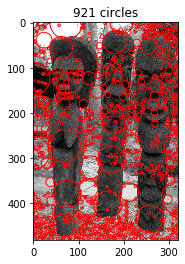

For part a, the runtime for image 119082.jpg is: 0.42971301078796387 s


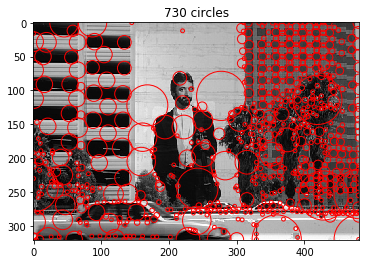

For part a, the runtime for image 182053.jpg is: 0.45380592346191406 s


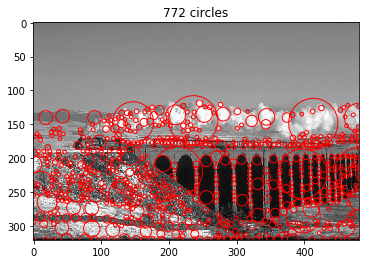

For part a, the runtime for image 210088.jpg is: 0.4279952049255371 s


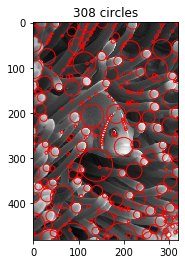

For part a, the runtime for image butterfly.jpg is: 0.48966503143310547 s


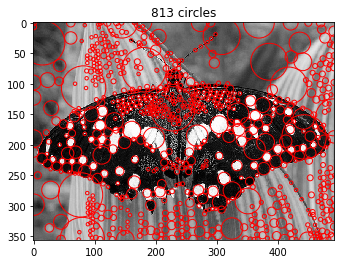

For part a, the runtime for image einstein.jpg is: 0.8933761119842529 s


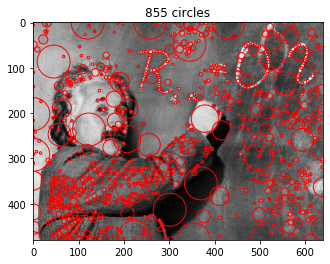

For part a, the runtime for image fishes.jpg is: 0.4497826099395752 s


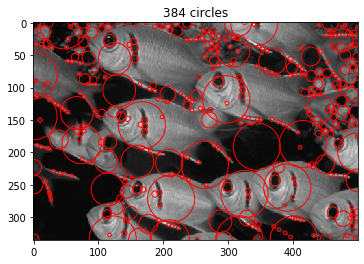

For part a, the runtime for image sunflowers.jpg is: 0.32521581649780273 s


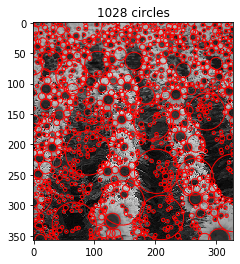

In [16]:
draw_circle(0)

For part b, the runtime for image 101085.jpg is: 0.24953126907348633 s


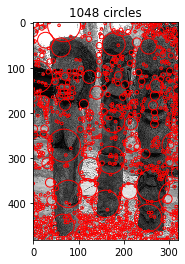

For part b, the runtime for image 119082.jpg is: 0.24089598655700684 s


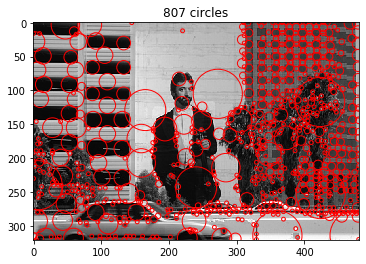

For part b, the runtime for image 182053.jpg is: 0.24434399604797363 s


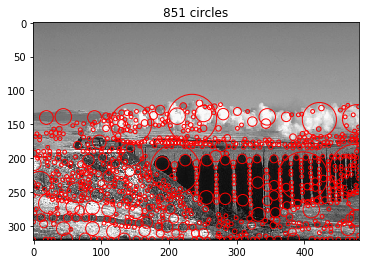

For part b, the runtime for image 210088.jpg is: 0.2416398525238037 s


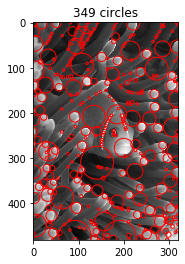

For part b, the runtime for image butterfly.jpg is: 0.27574610710144043 s


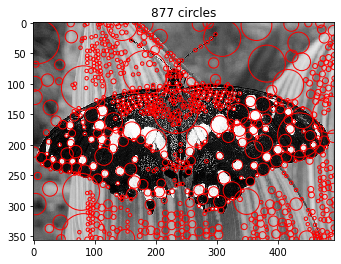

For part b, the runtime for image einstein.jpg is: 0.5380899906158447 s


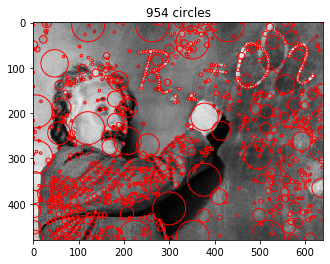

For part b, the runtime for image fishes.jpg is: 0.25576090812683105 s


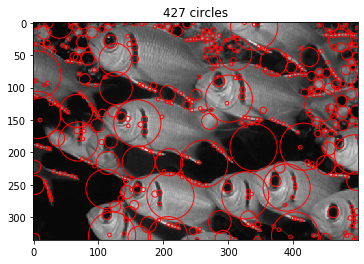

For part b, the runtime for image sunflowers.jpg is: 0.19141411781311035 s


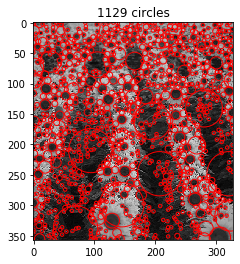

In [17]:
draw_circle(1)